In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [124]:
!pip install scikit-learn==1.5.2
# There was incompability with two libraries when using sklearn version > 1.6. So i downgraded it.

In [5]:
import numpy as np
import pandas as pd
import kagglehub
import sklearn
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, learning_curve
from sklearn.metrics import mean_squared_error, r2_score
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import os


import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LeakyReLU, Input, Dropout, LSTM, GRU, Conv1D
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.activations import linear, relu, sigmoid
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import RootMeanSquaredError

In [7]:
sklearn.__version__

'1.5.2'

In [8]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/FloodPrediction.csv")

In [9]:
df.head()

,Sl,Station_Names,Year,Month,Max_Temp,Min_Temp,Rainfall,Relative_Humidity,Wind_Speed,Cloud_Coverage,Bright_Sunshine,Station_Number,X_COR,Y_COR,LATITUDE,LONGITUDE,ALT,Period,Flood?
0,0,Barisal,1949,1,29.4,12.3,0.0,68.0,0.453704,0.6,7.831915,41950,536809.8,510151.9,22.7,90.36,4,1949.01,NaN
1,1,Barisal,1949,2,33.9,15.2,9.0,63.0,0.659259,0.9,8.314894,41950,536809.8,510151.9,22.7,90.36,4,1949.02,NaN
2,2,Barisal,1949,3,36.7,20.2,8.0,59.0,1.085185,1.5,8.131915,41950,536809.8,510151.9,22.7,90.36,4,1949.03,NaN
3,3,Barisal,1949,4,33.9,23.9,140.0,71.0,1.772222,3.9,8.219149,41950,536809.8,510151.9,22.7,90.36,4,1949.04,NaN
4,4,Barisal,1949,5,35.6,25.0,217.0,76.0,1.703704,4.1,7.046809,41950,536809.8,510151.9,22.7,90.36,4,1949.05,NaN


In [10]:
# df.describe()
df.info()
df.isnull().sum() # checking for missing data

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20544 entries, 0 to 20543
Data columns (total 19 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Sl                 20544 non-null  int64  
 1   Station_Names      20544 non-null  object 
 2   Year               20544 non-null  int64  
 3   Month              20544 non-null  int64  
 4   Max_Temp           20544 non-null  float64
 5   Min_Temp           20544 non-null  float64
 6   Rainfall           20544 non-null  float64
 7   Relative_Humidity  20544 non-null  float64
 8   Wind_Speed         20544 non-null  float64
 9   Cloud_Coverage     20544 non-null  float64
 10  Bright_Sunshine    20544 non-null  float64
 11  Station_Number     20544 non-null  int64  
 12  X_COR              20544 non-null  float64
 13  Y_COR              20544 non-null  float64
 14  LATITUDE           20544 non-null  float64
 15  LONGITUDE          20544 non-null  float64
 16  ALT                205

,0
Sl,0
Station_Names,0
Year,0
Month,0
Max_Temp,0
Min_Temp,0
Rainfall,0
Relative_Humidity,0
Wind_Speed,0
Cloud_Coverage,0


In [11]:
df['Station_Names'].describe()

,Station_Names
count,20544
unique,33
top,Khulna
freq,792


In [12]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
df['Station_Names'] = label_encoder.fit_transform(df['Station_Names'])

In [13]:
df["Flood?"].fillna(0, inplace=True)

<ipython-input-13-5317a140b166>:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["Flood?"].fillna(0, inplace=True)


In [14]:
# Removing unnecessary columns

df.drop(['Sl','Station_Names', 'Year', 'Month', 'Station_Number', 'X_COR', 'Y_COR', 'LATITUDE', 'LONGITUDE'], axis = 1, inplace = True)

In [15]:
df.set_index("Period", inplace=True)

In [16]:
df.head()

,Max_Temp,Min_Temp,Rainfall,Relative_Humidity,Wind_Speed,Cloud_Coverage,Bright_Sunshine,ALT,Flood?
Period,,,,,,,,,
1949.01,29.4,12.3,0.0,68.0,0.453704,0.6,7.831915,4,0.0
1949.02,33.9,15.2,9.0,63.0,0.659259,0.9,8.314894,4,0.0
1949.03,36.7,20.2,8.0,59.0,1.085185,1.5,8.131915,4,0.0
1949.04,33.9,23.9,140.0,71.0,1.772222,3.9,8.219149,4,0.0
1949.05,35.6,25.0,217.0,76.0,1.703704,4.1,7.046809,4,0.0


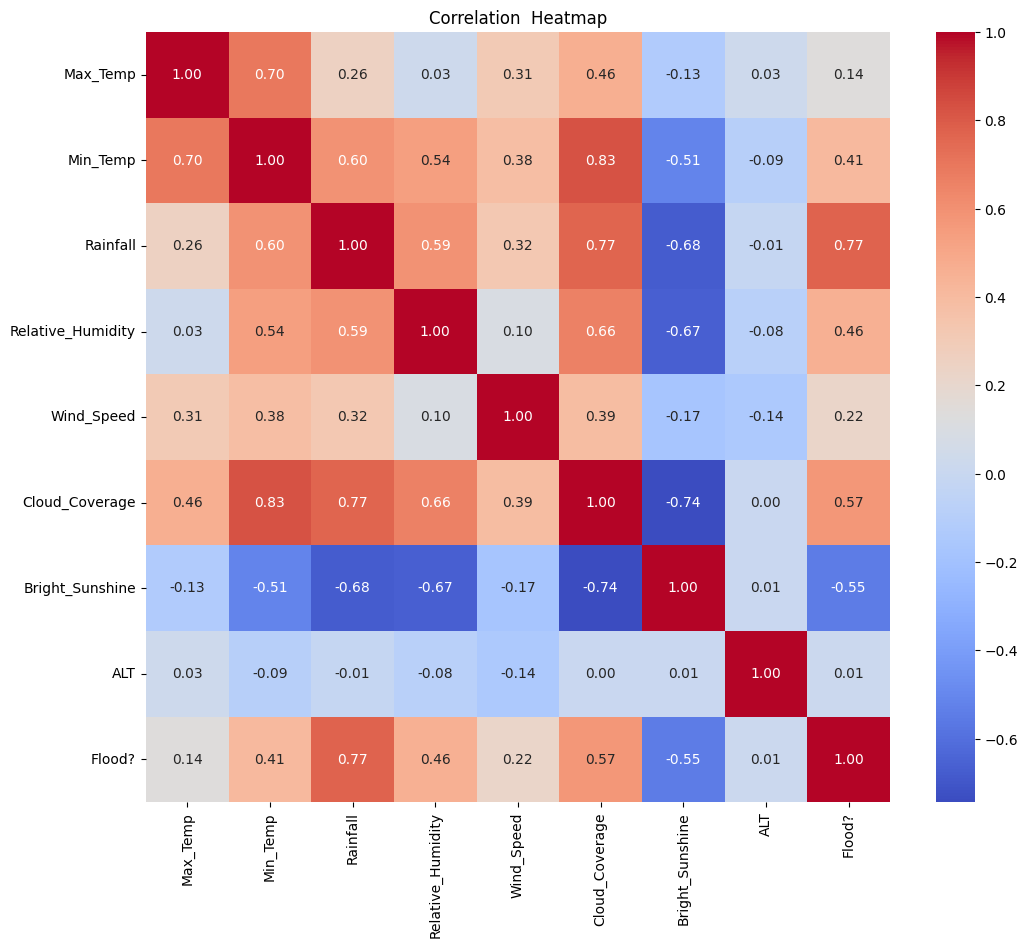

In [17]:
plt.figure(figsize=(12, 10))
sns.heatmap(df.corr(), annot=True, cmap = "coolwarm", fmt = ".2f")
plt.title("Correlation  Heatmap")
plt.show()
#result shows no correlation

In [18]:
# listing all comuns name of dataframe
all_columns = df.columns
all_columns, len(all_columns)

(Index(['Max_Temp', 'Min_Temp', 'Rainfall', 'Relative_Humidity', 'Wind_Speed',
        'Cloud_Coverage', 'Bright_Sunshine', 'ALT', 'Flood?'],
       dtype='object'),
 9)

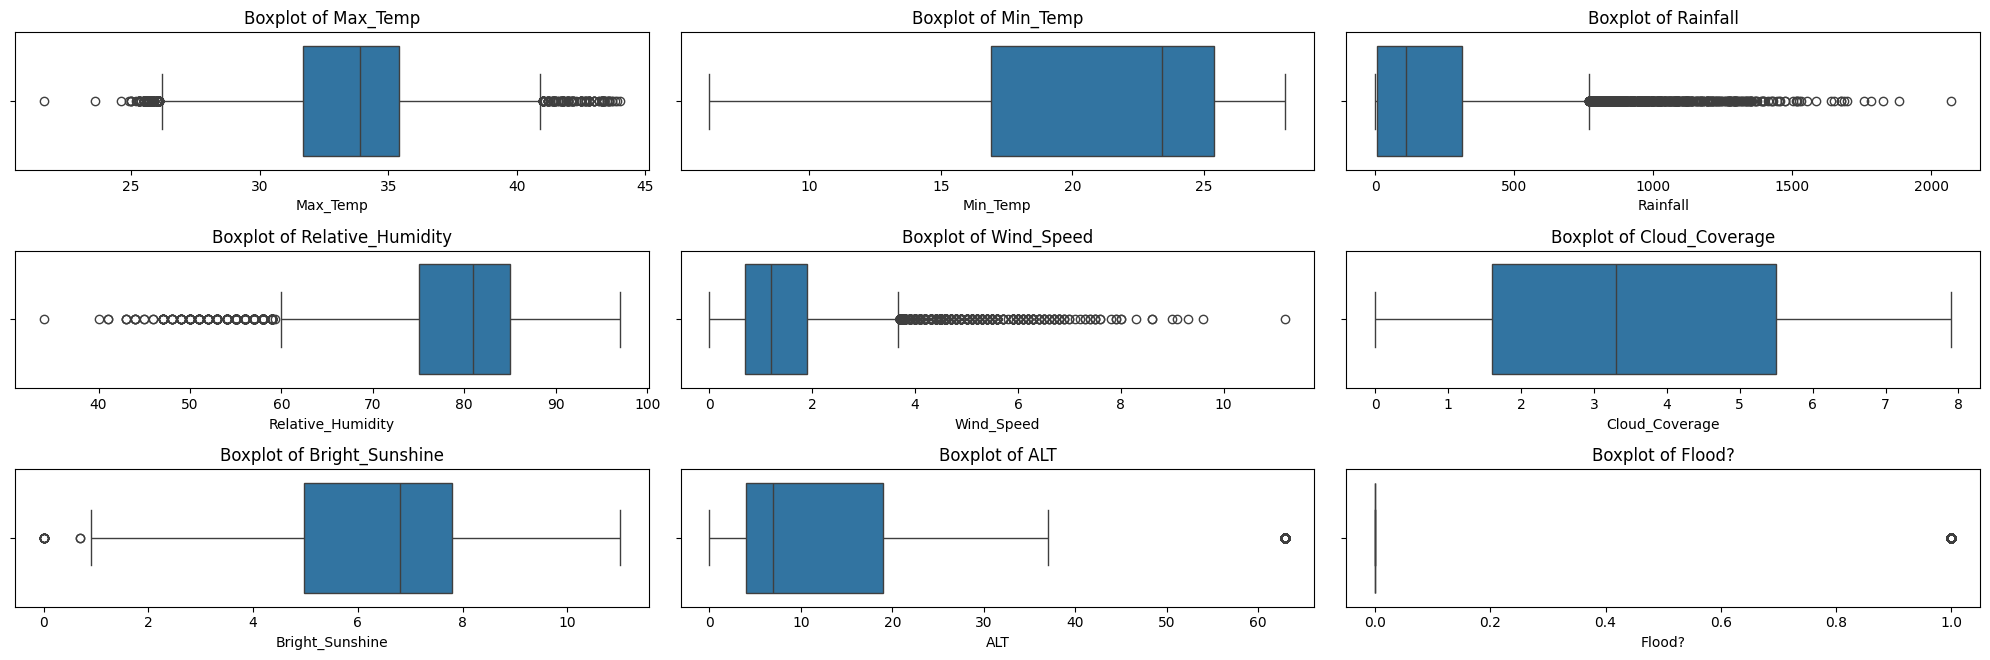

In [19]:
columns = [
    'Max_Temp', 'Min_Temp', 'Rainfall', 'Relative_Humidity', 'Wind_Speed',
        'Cloud_Coverage', 'Bright_Sunshine', 'ALT', 'Flood?'
]

# Create a 3x6 grid of subplots (adjusting layout for 17 columns)
fig, axes = plt.subplots(7, 3, figsize=(20, 15))  # 6 rows, 3 columns grid

# Flatten axes array for easier indexing
axes = axes.flatten()

# Iterate over columns and corresponding axes
for i, column in enumerate(columns):
    sns.boxplot(ax=axes[i], data=df, x=column)  # Pass the `ax` to sns.boxplot
    axes[i].set_title(f"Boxplot of {column}")

# Hide any unused subplots if the number of columns doesn't fill the grid
for j in range(len(columns), len(axes)):
    fig.delaxes(axes[j])

# Adjust spacing to prevent overlap
plt.tight_layout()
plt.show()

# Determining X and y

In [20]:
# X and y dataset as 2-D arrays
X = df.loc[:, all_columns.drop('Flood?')].values
y  = df.loc[:, 'Flood?'].values

In [21]:
# converting y into 2-D
y = y.reshape(-1, 1)

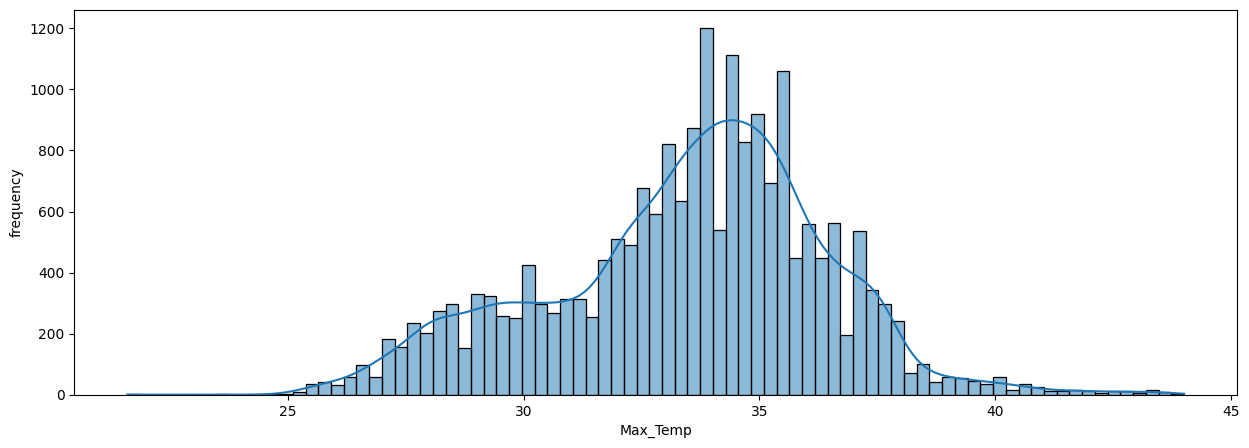

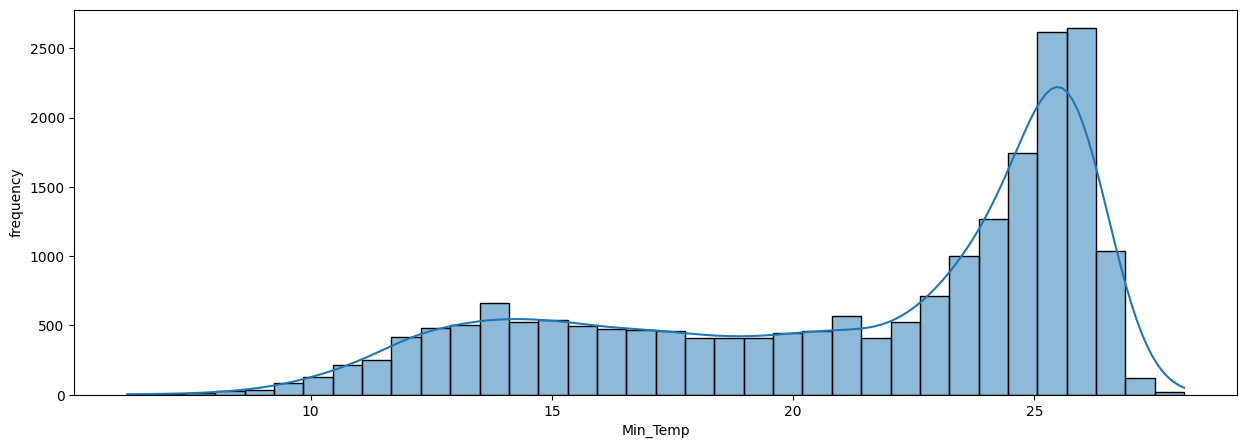

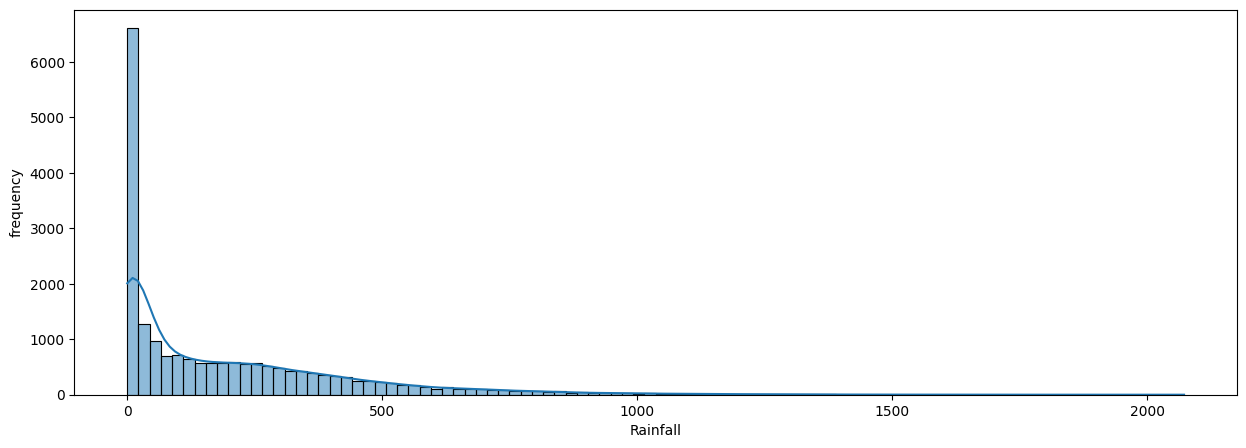

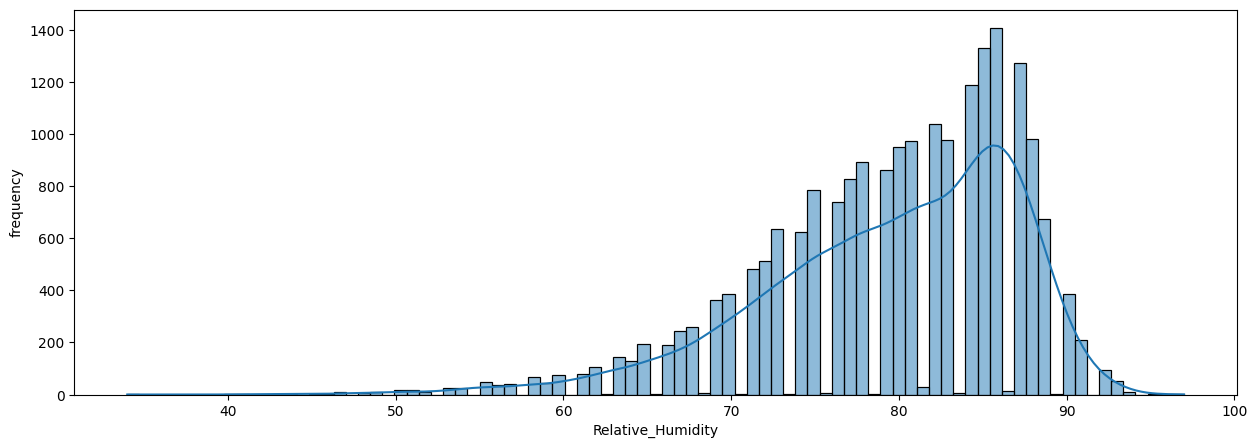

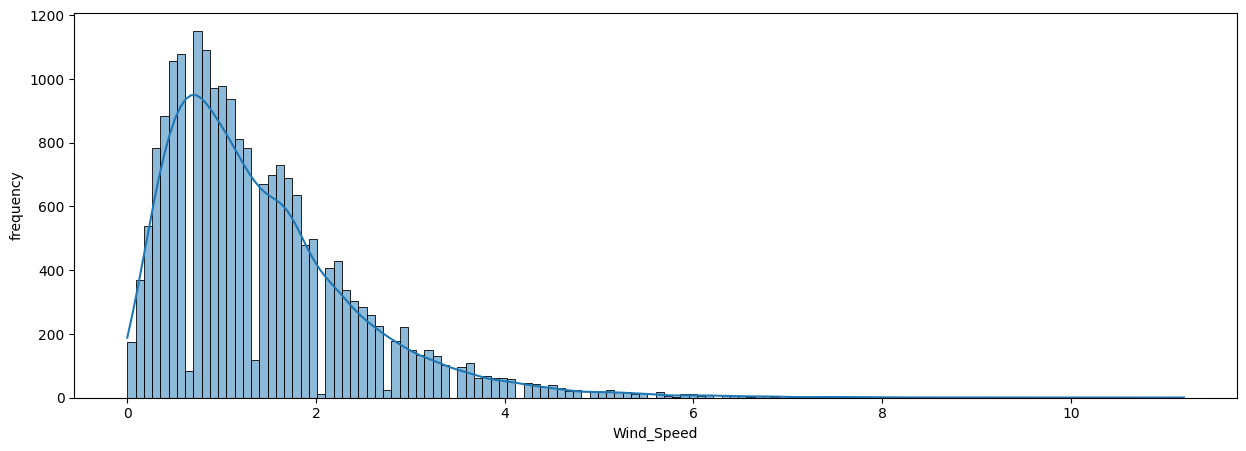

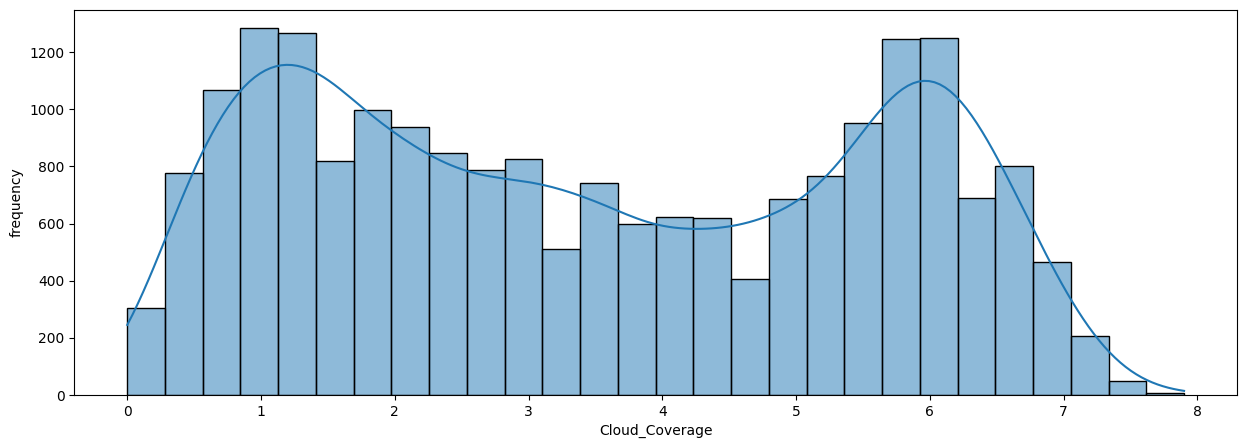

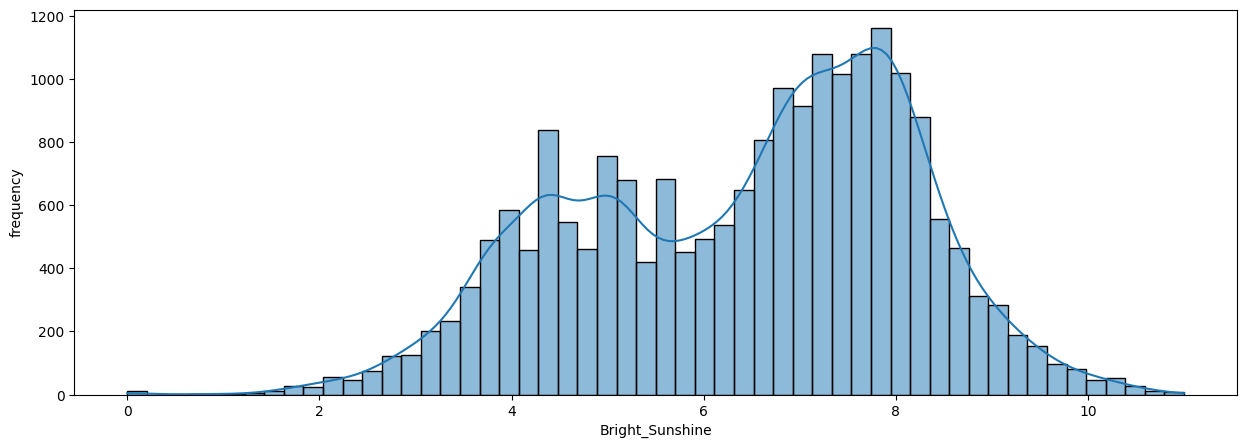

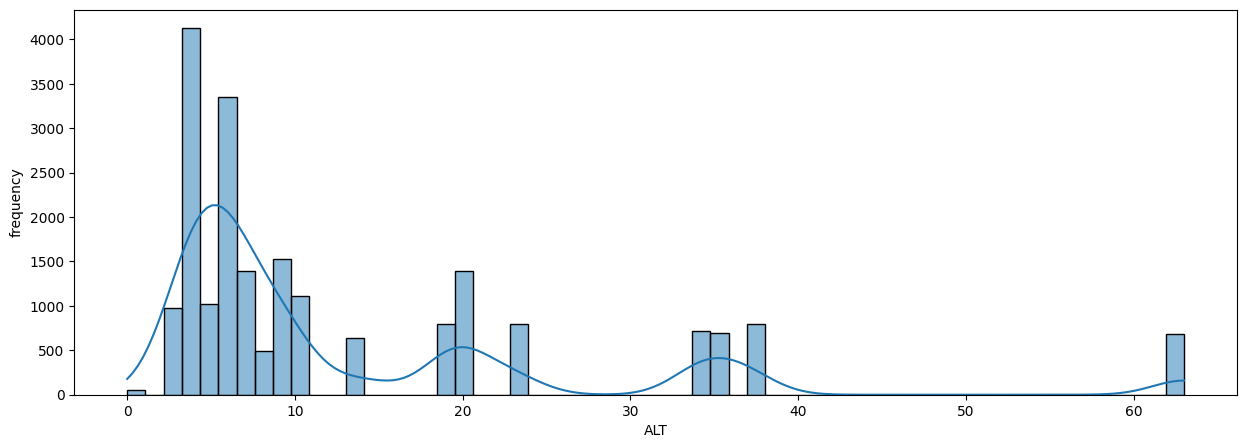

In [22]:
# histogram visualization
for i in range(len(df.drop(['Flood?'], axis = 1).columns.values)):
  plt.figure(figsize=(15, 5))
  sns.histplot(X[:, i], kde = True)
  plt.xlabel(df.columns.values[i])
  plt.ylabel('frequency')
  plt.show()

<Axes: ylabel='Count'>

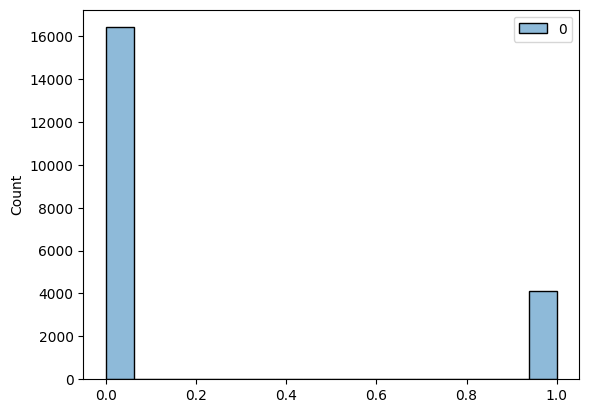

In [23]:
sns.histplot(y)

In [24]:
# Normalizing the given data

from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

# since histogram shows all the data to be normally distributed, no need for standard scaling.

# Split dataset into training and testing

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

# Training the model

In [57]:
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators= 100, random_state = 0)

## Hyperparameter tuning

In [58]:
# Initilize the ranges of Hyperparameters

param_grid_rfc = {
    # "n_estimators": [50, 100, 200]
    # "max_features": ["sqrt", "log2"],
    "max_depth" : [None, 10, 20]
    # "min_samples_split": [2, 5, 10],
    # "min_samples_leaf": [1, 2, 4]
}

In [59]:
# hyperparameter tuning
grid_search_rfc = GridSearchCV(estimator = classifier, param_grid = param_grid_rfc, cv = 5,
                              n_jobs =-1, verbose = 2)
bestmodelRFC = grid_search_rfc.fit(X_train, y_train)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:1473: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


In [60]:
best_rfc_model = grid_search_rfc.best_estimator_

print(best_rfc_model)
print("best parameters for random forest:", grid_search_rfc.best_params_)

RandomForestClassifier(max_depth=20, random_state=0)
best parameters for random forest: {'max_depth': 20}


In [61]:
cv_scores_rfc  = cross_val_score(best_rfc_model, X_train, y_train.reshape(-1), cv = 5)
print("Cross Validation scores:", cv_scores_rfc)
print("mean")

Cross Validation scores: [0.96440523 0.95862489 0.96075449 0.95862489 0.9619714 ]
mean


In [62]:
y_pred_rfc = best_rfc_model.predict(X_test)

print("test_accuracy_score:", mean_squared_error(y_test, y_pred_rfc))
print("test set confusion matrix:\n", r2_score(y_test, y_pred_rfc))
y_pred_rfc

test_accuracy_score: 0.04258943781942078
test set confusion matrix:
 0.7415416743045895


array([0., 0., 0., ..., 0., 0., 0.])

In [63]:
OptimumClassifier_rfc = RandomForestClassifier(n_estimators= 100, max_depth = 20, random_state = 0)
OptimumClassifier_rfc.fit(X_train, y_train.reshape(-1))

RandomForestClassifier(max_depth=20, random_state=0)

## Plotting the acccuracy vs trainsize curve for assessing the performance of the model

In [64]:
train_sizes, train_scores, test_scores = learning_curve(OptimumClassifier_rfc, X_train, y_train.reshape(-1), cv = 5, scoring='neg_mean_squared_error', verbose = 2)

[learning_curve] Training set sizes: [ 1314  4273  7231 10189 13148]
[CV] END .................................................... total time=   0.6s
[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   1.2s
[CV] END .................................................... total time=   1.1s
[CV] END .................................................... total time=   1.3s
[CV] END .................................................... total time=   0.3s
[CV] END .................................................... total time=   0.5s
[CV] END .................................................... total time=   0.8s
[CV] END .................................................... total time=   1.1s
[CV] END .................................................... total time=   1.3s
[CV] END .................................................... total time=   0.3s
[CV] END ...............................

In [65]:
train_mean =np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis = 1)
test_mean =np.mean(test_scores, axis = 1)
test_std = np.std(test_scores, axis = 1)

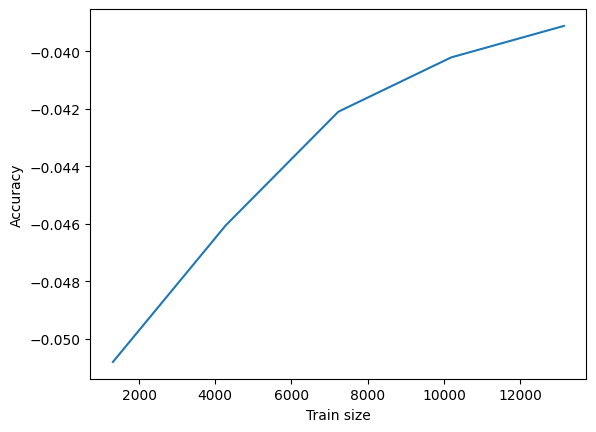

In [66]:
# plt.plot(train_sizes, train_mean, label = "Training Error")
plt.plot(train_sizes, test_mean, label = "Cross-validation Error rfc")
plt.xlabel("Train size")
plt.ylabel("Accuracy")
plt.show()

## Save random forest regressor model in pickle

In [67]:
# save model and feature names to  a pickle file

model_data_rfc = {"model_rfc": best_rfc_model, "feature_names": df.columns.values.tolist()}

with open("flood_prediction_RandomForestClassifier.pk1", "wb") as file:
  pickle.dump(model_data_rfc, file)

### Load the saved random forest regressor model from pickle file and use it for prediction

In [68]:
import pickle
import pandas as pd

In [69]:
with open("flood_prediction_RandomForestClassifier.pk1", "rb") as file:
  model_data_rfc = pickle.load(file)

In [70]:
model_rfc = model_data_rfc["model_rfc"]
feature_names_rfc =  model_data_rfc["feature_names"]

In [71]:
prediction_rfc = best_rfc_model.predict(X_test)
print("test_accuracy_score:", r2_score(y_test, prediction_rfc))
print("test set confusion matrix:\n", mean_squared_error(y_test, prediction_rfc))

test_accuracy_score: 0.7415416743045895
test set confusion matrix:
 0.04258943781942078


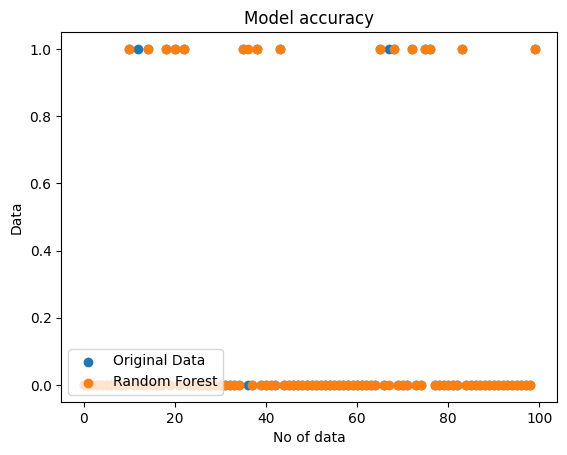

In [72]:
plt.scatter(range(len(y_test[:100])), y_test[:100])
plt.scatter( range(len(prediction_rfc[:100])), prediction_rfc[:100])
plt.xlabel('No of data')
plt.ylabel('Data')
plt.title('Model accuracy')
plt.legend(["Original Data", "Random Forest"], loc="lower left")
plt.show()

# Neural Network Model for flood data

In [27]:
tf.random.set_seed(1234)  # applied to achieve consistent results

def create_model_nn(optimizer='adam'):
  classifier_nn = Sequential()
  classifier_nn.add(Input(shape=(X_train.shape[1],)))
  classifier_nn.add(Dense(16, activation='relu', name = 'layer1'))
  classifier_nn.add(Dense(8, activation='relu', name = 'layer2'))
  classifier_nn.add(Dense(1, activation='sigmoid', name = 'Outputlayer'))

  classifier_nn.compile(loss = 'binary_crossentropy',
    optimizer = optimizer,
    metrics = ['accuracy']
  )

  return classifier_nn

## Fitting the neural network model

In [28]:
# Initilize the ranges of Hyperparameters

param_grid_nn = {
    'optimizer': ['rmsprop', 'adam']
}

In [34]:
# ! pip install scikeras -q
cp_nn = ModelCheckpoint(filepath="best_NN_model.keras", save_best_only=True)

In [35]:

from scikeras.wrappers import KerasClassifier

classifier_nn = KerasClassifier(model = create_model_nn, epochs=10, verbose=2)

In [37]:
grid_nn = GridSearchCV(estimator = classifier_nn, param_grid = param_grid_nn, cv=5, scoring = 'accuracy')

In [39]:
grid_result_nn = grid_nn.fit(X_train, y_train, callbacks=[cp_nn])

Epoch 1/10
411/411 - 6s - 15ms/step - accuracy: 0.9002 - loss: 0.2441
Epoch 2/10
411/411 - 1s - 3ms/step - accuracy: 0.9390 - loss: 0.1532
Epoch 3/10
411/411 - 1s - 3ms/step - accuracy: 0.9406 - loss: 0.1454
Epoch 4/10
411/411 - 2s - 4ms/step - accuracy: 0.9417 - loss: 0.1423
Epoch 5/10
411/411 - 3s - 6ms/step - accuracy: 0.9427 - loss: 0.1403
Epoch 6/10
411/411 - 3s - 6ms/step - accuracy: 0.9431 - loss: 0.1388
Epoch 7/10
411/411 - 3s - 7ms/step - accuracy: 0.9436 - loss: 0.1378
Epoch 8/10
411/411 - 3s - 8ms/step - accuracy: 0.9447 - loss: 0.1368
Epoch 9/10
411/411 - 2s - 4ms/step - accuracy: 0.9453 - loss: 0.1360
Epoch 10/10
411/411 - 2s - 4ms/step - accuracy: 0.9455 - loss: 0.1353
103/103 - 0s - 2ms/step
Epoch 1/10
411/411 - 2s - 4ms/step - accuracy: 0.8928 - loss: 0.2790
Epoch 2/10
411/411 - 1s - 1ms/step - accuracy: 0.9379 - loss: 0.1538
Epoch 3/10
411/411 - 1s - 2ms/step - accuracy: 0.9407 - loss: 0.1458
Epoch 4/10
411/411 - 1s - 3ms/step - accuracy: 0.9420 - loss: 0.1422
Epoch 5/

In [40]:
best_model_nn = grid_nn.best_estimator_

print(best_model_nn)
print("best parameters for ANN:", grid_nn.best_params_)

KerasClassifier(
	model=<function create_model_nn at 0x7a1a35fedf30>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=2
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=10
	class_weight=None
)
best parameters for ANN: {'optimizer': 'adam'}


In [41]:
bestClassifier_nn = create_model_nn(grid_nn.best_params_['optimizer'])
# cp_nn = ModelCheckpoint(filepath="best_NN_model.keras", save_best_only=True)
HistoryBest_nn = bestClassifier_nn.fit(x = X_train, y = y_train, batch_size = 16, epochs =10, verbose = 2)

Epoch 1/10
1028/1028 - 3s - 3ms/step - accuracy: 0.9069 - loss: 0.2342
Epoch 2/10
1028/1028 - 3s - 3ms/step - accuracy: 0.9410 - loss: 0.1473
Epoch 3/10
1028/1028 - 3s - 3ms/step - accuracy: 0.9427 - loss: 0.1416
Epoch 4/10
1028/1028 - 2s - 2ms/step - accuracy: 0.9441 - loss: 0.1385
Epoch 5/10
1028/1028 - 2s - 1ms/step - accuracy: 0.9452 - loss: 0.1365
Epoch 6/10
1028/1028 - 3s - 2ms/step - accuracy: 0.9463 - loss: 0.1348
Epoch 7/10
1028/1028 - 1s - 1ms/step - accuracy: 0.9464 - loss: 0.1334
Epoch 8/10
1028/1028 - 3s - 2ms/step - accuracy: 0.9468 - loss: 0.1322
Epoch 9/10
1028/1028 - 2s - 2ms/step - accuracy: 0.9474 - loss: 0.1311
Epoch 10/10
1028/1028 - 3s - 3ms/step - accuracy: 0.9479 - loss: 0.1301


## Plotting the loss curve for determining model performance

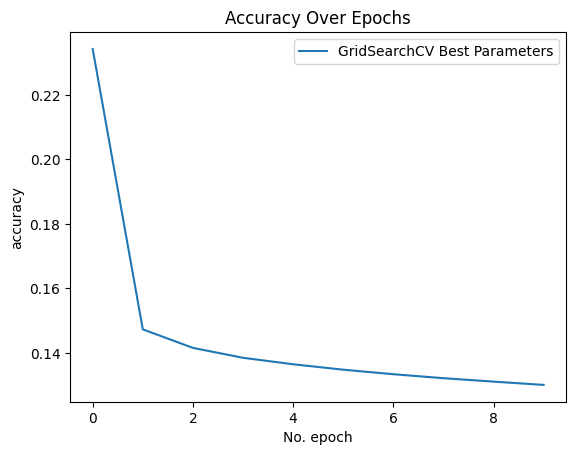

In [42]:
plt.plot(HistoryBest_nn.history['loss'], label='GridSearchCV Best Parameters')
plt.title('Accuracy Over Epochs')
plt.ylabel('accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

In [43]:
cv_scores_nn  = cross_val_score(best_model_nn, X_train, y_train, cv = 5)
print("Cross Validation scores:", cv_scores_nn)
print("mean:", np.mean(cv_scores_nn))

Epoch 1/10
411/411 - 2s - 4ms/step - accuracy: 0.9063 - loss: 0.2337
Epoch 2/10
411/411 - 1s - 1ms/step - accuracy: 0.9400 - loss: 0.1524
Epoch 3/10
411/411 - 1s - 2ms/step - accuracy: 0.9414 - loss: 0.1458
Epoch 4/10
411/411 - 1s - 2ms/step - accuracy: 0.9434 - loss: 0.1423
Epoch 5/10
411/411 - 2s - 4ms/step - accuracy: 0.9449 - loss: 0.1397
Epoch 6/10
411/411 - 1s - 3ms/step - accuracy: 0.9458 - loss: 0.1374
Epoch 7/10
411/411 - 1s - 3ms/step - accuracy: 0.9458 - loss: 0.1355
Epoch 8/10
411/411 - 1s - 2ms/step - accuracy: 0.9467 - loss: 0.1340
Epoch 9/10
411/411 - 1s - 3ms/step - accuracy: 0.9476 - loss: 0.1328
Epoch 10/10
411/411 - 1s - 3ms/step - accuracy: 0.9480 - loss: 0.1318
103/103 - 0s - 4ms/step
Epoch 1/10
411/411 - 3s - 7ms/step - accuracy: 0.8700 - loss: 0.3266
Epoch 2/10
411/411 - 1s - 2ms/step - accuracy: 0.9392 - loss: 0.1547
Epoch 3/10
411/411 - 1s - 1ms/step - accuracy: 0.9433 - loss: 0.1438
Epoch 4/10
411/411 - 1s - 2ms/step - accuracy: 0.9452 - loss: 0.1402
Epoch 5/1

In [45]:
y_pred_nn = bestClassifier_nn.predict(X_test)
y_pred_nn = [0 if a < 0.5 else 1 for a in y_pred_nn]

print("test_accuracy_score:", mean_squared_error(y_test, y_pred_nn))
print("test set confusion matrix:\n", r2_score(y_test, y_pred_nn))
# y_pred_nn

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
test_accuracy_score: 0.06303236797274275
test set confusion matrix:
 0.6174816779707926


## Save neural network model in pickle file

In [46]:
# save model and feature names to  a pickle file

model_data_nn = {"model_nn": bestClassifier_nn, "feature_names_nn": df.columns.values.tolist()}

with open("flood_prediction_neural_network.pk1", "wb") as file:
  pickle.dump(model_data_nn, file)

### Load the saved neural network model from file and use it for prediction

In [47]:
import pickle
import pandas as pd

In [48]:
with open("flood_prediction_neural_network.pk1", "rb") as file:
  model_data_nn = pickle.load(file)

In [49]:
model_nn = model_data_nn["model_nn"]
feature_names_nn =  model_data_nn["feature_names_nn"]

In [52]:
prediction_nn = model_nn.predict(X_test)
prediction_nn = [0 if a < 0.5 else 1 for a in prediction_nn]
print("test_accuracy_score:", mean_squared_error(y_test, prediction_nn))
print("test set confusion matrix:\n", r2_score(y_test, prediction_nn))

129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
test_accuracy_score: 0.06303236797274275
test set confusion matrix:
 0.6174816779707926


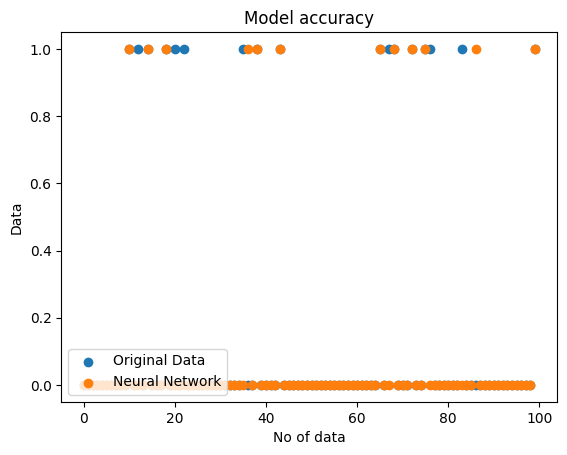

In [54]:
plt.scatter( range(len(y_test[:100])) ,y_test[:100])
plt.scatter( range(len(prediction_nn[:100])),prediction_nn[:100])
plt.xlabel('No of data')
plt.ylabel('Data')
plt.title('Model accuracy')
plt.legend(["Original Data", "Neural Network"], loc="lower left")
plt.show()

## Comparasion between Neural Network model and Random Forest Regressor model

In [74]:
mean_squared_error(y_test, prediction_nn), mean_squared_error(y_test, prediction_rfc)

# Neural Network is more accurate than Random Forest regressor

(0.06303236797274275, 0.04258943781942078)

# LSTM model

## Data Preparation

In [94]:
df

,Max_Temp,Min_Temp,Rainfall,Relative_Humidity,Wind_Speed,Cloud_Coverage,Bright_Sunshine,ALT,Flood?
Period,,,,,,,,,
1949.01,29.4,12.3,0.0,68.0,0.453704,0.6,7.831915,4,0.0
1949.02,33.9,15.2,9.0,63.0,0.659259,0.9,8.314894,4,0.0
1949.03,36.7,20.2,8.0,59.0,1.085185,1.5,8.131915,4,0.0
1949.04,33.9,23.9,140.0,71.0,1.772222,3.9,8.219149,4,0.0
1949.05,35.6,25.0,217.0,76.0,1.703704,4.1,7.046809,4,0.0
...,...,...,...,...,...,...,...,...,...
2013.08,32.5,25.4,851.0,88.0,2.500000,6.2,3.800000,4,1.0
2013.09,32.6,25.7,329.0,88.0,3.000000,6.1,4.200000,4,0.0
2013.10,33.1,24.8,271.0,85.0,2.500000,4.4,5.600000,4,0.0


### Function for preparing dataset for LSTM model

In [95]:
def df_to_X_y(df, window_size):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [a for a in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][8]
        y.append(label)
    return np.array(X), np.array(y)

In [96]:
Window_size = 10
X_LSTM, y_LSTM = df_to_X_y(df, Window_size)
X_LSTM.shape, y_LSTM.shape
X_LSTM.shape[1], X_LSTM.shape[2]

(10, 9)

In [97]:
y_LSTM = y_LSTM.reshape(-1, 1)
y_LSTM.shape

(20534, 1)

In [98]:
X_train_LSTM, X_test_LSTM, y_train_LSTM, y_test_LSTM = train_test_split(X_LSTM, y_LSTM, test_size = 0.2, random_state = 0)

In [99]:
X_train_LSTM.shape, X_test_LSTM.shape, y_train_LSTM.shape, y_test_LSTM.shape

((16427, 10, 9), (4107, 10, 9), (16427, 1), (4107, 1))

In [100]:
# print(X_train_LSTM)

In [101]:
# from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

In [102]:
# Window_size = 5
# train_generator = TimeseriesGenerator(X_train, y_train, length=Window_size, batch_size=128)
# test_generator = TimeseriesGenerator(X_test, y_test, length=Window_size, batch_size=128)

In [103]:
# train_generator.length
# x_gen, y_gen = train_generator[0]

## Building LSTM model

In [104]:
from tensorflow.keras.initializers import GlorotUniform

initializer = GlorotUniform()

In [105]:
from tensorflow.keras.regularizers import l2

model1 = Sequential()
model1.add(Input(shape=(X_train_LSTM.shape[1], X_train_LSTM.shape[2])))
model1.add(LSTM(8))
model1.add(Dropout(0.2))
model1.add(Dense(8, activation='relu'))
model1.add(Dense(1, activation='sigmoid'))

model1.summary()

Model: "sequential_18"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                        │ (None, 8)                   │             576 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 8)                   │              72 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │               9 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 657 (2.57 KB)

 Trainable params: 657 (2.57 KB)

 Non-trainable params: 0 (0.00 B)

In [106]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)

In [107]:
cp = ModelCheckpoint(filepath="best_LSTM_model.keras", save_best_only=True)
model1.compile( loss=BinaryCrossentropy() , optimizer=Adam(learning_rate=0.001), metrics=[RootMeanSquaredError()])

In [108]:
for layer in model1.layers:
    if hasattr(layer, 'reset_states'):
        layer.reset_states()

In [109]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='train_loss', patience=3, restore_best_weights=True, mode='min')

In [110]:
history_model = model1.fit(X_train_LSTM, y_train_LSTM, batch_size=32, validation_split = 0.2, epochs=20, callbacks=[cp, lr_scheduler, early_stopping])

Epoch 1/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - loss: 0.5559 - root_mean_squared_error: 0.4328 - val_loss: 0.3677 - val_root_mean_squared_error: 0.3439 - learning_rate: 0.0010
Epoch 2/20
 13/411 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - loss: 0.3389 - root_mean_squared_error: 0.3273

/usr/local/lib/python3.10/dist-packages/keras/src/callbacks/early_stopping.py:155: UserWarning: Early stopping conditioned on metric `train_loss` which is not available. Available metrics are: loss,root_mean_squared_error,val_loss,val_root_mean_squared_error,learning_rate
  current = self.get_monitor_value(logs)


411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.3859 - root_mean_squared_error: 0.3535 - val_loss: 0.3537 - val_root_mean_squared_error: 0.3383 - learning_rate: 0.0010
Epoch 3/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step - loss: 0.3794 - root_mean_squared_error: 0.3513 - val_loss: 0.3456 - val_root_mean_squared_error: 0.3359 - learning_rate: 0.0010
Epoch 4/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - loss: 0.3694 - root_mean_squared_error: 0.3469 - val_loss: 0.3420 - val_root_mean_squared_error: 0.3346 - learning_rate: 0.0010
Epoch 5/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.3667 - root_mean_squared_error: 0.3456 - val_loss: 0.3370 - val_root_mean_squared_error: 0.3321 - learning_rate: 0.0010
Epoch 6/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - loss: 0.3659 - root_mean_squared_error: 0.3459 - val_loss: 0.3327 - val_root_mean_squared_error: 0.3301 - learning_rate: 0.0010
Epoch 7/20
411/411 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.3598 - root_mean_squared_error: 0.3431

In [111]:


if os.path.exists("best_LSTM_model.keras"):
    print("Checkpoint file saved successfully!")
else:
    print("Checkpoint file was not saved!")

Checkpoint file saved successfully!


## Load best LSTM model so far

In [112]:
# history_model.history

In [113]:
model1_best = load_model("best_LSTM_model.keras")

In [114]:
train_predictions = model1_best.predict(X_train_LSTM)
train_predictions = [0 if a < 0.5 else 1 for a in train_predictions]
test_predictions = model1_best.predict(X_test_LSTM)
test_predictions = [0 if a < 0.5 else 1 for a in test_predictions]

514/514 ━━━━━━━━━━━━━━━━━━━━ 4s 7ms/step
129/129 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


In [116]:
mean_squared_error(y_test_LSTM, test_predictions)

0.17993669345020696

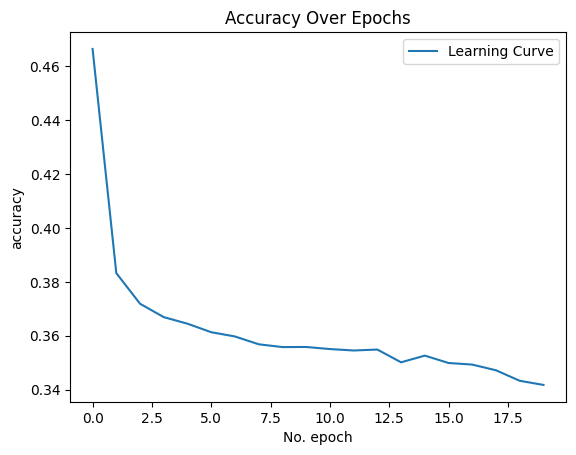

In [117]:
plt.plot(history_model.history['loss'], label='Learning Curve')
plt.title('Accuracy Over Epochs')
plt.ylabel('accuracy')
plt.xlabel('No. epoch')
plt.legend(loc="upper right")
plt.show()

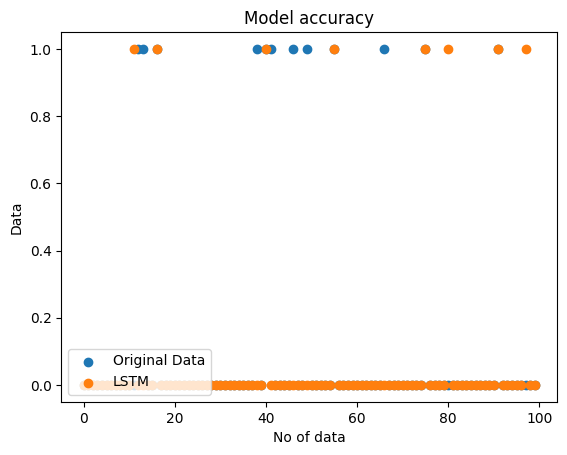

In [118]:
plt.scatter(range(len(y_train_LSTM[:100])), y_train_LSTM[:100])
plt.scatter( range(len(train_predictions[:100])), train_predictions[:100])
plt.xlabel('No of data')
plt.ylabel('Data')
plt.title('Model accuracy')
plt.legend(["Original Data", "LSTM"], loc="lower left")
plt.show()

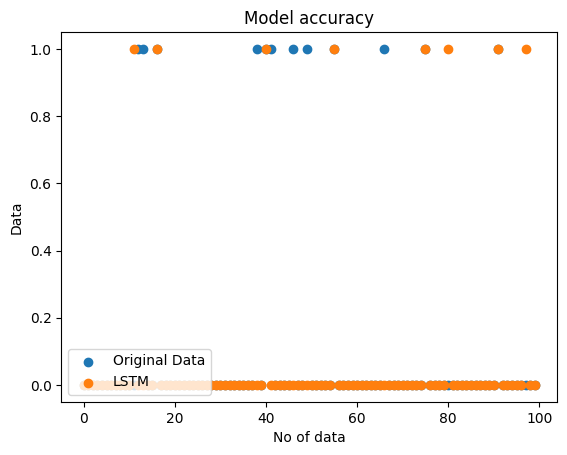

In [119]:
plt.scatter(range(len(y_train_LSTM[:100])), y_train_LSTM[:100])
plt.scatter( range(len(train_predictions[:100])), train_predictions[:100])
plt.xlabel('No of data')
plt.ylabel('Data')
plt.title('Model accuracy')
plt.legend(["Original Data", "LSTM"], loc="lower left")
plt.show()

# Model didn't  worked well due to vanishing gradient problem which is common for LSTM approach

## Comparasion between Neural Network model, Random Forest Regressor model and LSTM

In [121]:
mean_squared_error(y_test, prediction_nn), mean_squared_error(y_test, prediction_rfc), mean_squared_error(y_test_LSTM, test_predictions)

(0.06303236797274275, 0.04258943781942078, 0.17993669345020696)

In [122]:
# Thus, normal Neural Network worked best for the given dataset. LSTM performed the worst.